In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, UpSampling2D,
                                     concatenate, BatchNormalization, Activation, Dropout)
from tensorflow.keras.models import Model

# Configuration
IMG_HEIGHT, IMG_WIDTH = 256, 256
NUM_CLASSES = 3
BATCH_SIZE = 8
BUFFER_SIZE = 100
EPOCHS = 120

IMAGE_DIR = '/Users/salah/Desktop/intern/pipe_segmentation/images'
MASK_DIR = '/Users/salah/Desktop/intern/pipe_segmentation/generated_segmentation_masks'

# Preprocess masks
def preprocess_mask(mask):
    mask = np.where(mask == 127, 1, mask)
    mask = np.where(mask == 255, 2, mask)
    mask = np.where(mask < 1, 0, mask)
    return mask.astype(np.uint8)

# Load images and masks
image_files = sorted([f for f in os.listdir(IMAGE_DIR) if f.endswith('.png')])
mask_files = sorted([f for f in os.listdir(MASK_DIR) if f.endswith('.png')])

image_dict = {os.path.splitext(f)[0]: f for f in image_files}
mask_dict = {os.path.splitext(f)[0].replace('_processed_annotated_mask', ''): f for f in mask_files}

X, Y = [], []

for base_name, img_file in image_dict.items():
    if base_name in mask_dict:
        img = cv2.imread(os.path.join(IMAGE_DIR, img_file))
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))

        mask = cv2.imread(os.path.join(MASK_DIR, mask_dict[base_name]), cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)
        mask = preprocess_mask(mask)

        X.append(img)
        Y.append(mask)

X = np.array(X, dtype=np.uint8)
Y = np.array(Y, dtype=np.uint8)

# One-hot encode masks
Y = tf.keras.utils.to_categorical(Y, num_classes=NUM_CLASSES)

# Train/val/test split
X_temp, X_test, Y_temp, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size=0.2, random_state=42)

# Class weights (inversely proportional)
Y_train_labels = np.argmax(Y_train, axis=-1).astype(np.uint8)
all_pixels = Y_train_labels.flatten()
pixel_counts = Counter(all_pixels)
total_pixels = len(all_pixels)

class_weights = {cls: total_pixels / (NUM_CLASSES * count) for cls, count in pixel_counts.items()}
clipped_weights = {k: min(v, 20.0) for k, v in class_weights.items()}
weights_tensor = tf.constant([clipped_weights[i] for i in range(NUM_CLASSES)], dtype=tf.float32)

2025-07-30 19:14:28.111464: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-07-30 19:14:28.111508: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-07-30 19:14:28.111513: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1753899268.111894 3365645 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1753899268.111923 3365645 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [2]:
# Augmentation
def augment(image, mask):
    image = tf.cast(image, tf.float32)
    mask = tf.cast(mask, tf.float32)  # Keep mask as float32 one-hot

    seed = tf.random.uniform([], maxval=10000, dtype=tf.int32)

    # Apply flips spatially to both
    image = tf.image.stateless_random_flip_left_right(image, seed=[seed, 0])
    mask = tf.image.stateless_random_flip_left_right(mask, seed=[seed, 0])
    image = tf.image.stateless_random_flip_up_down(image, seed=[seed, 1])
    mask = tf.image.stateless_random_flip_up_down(mask, seed=[seed, 1])

    # Apply photometric changes ONLY to the image
    image = tf.image.stateless_random_brightness(image, max_delta=0.2, seed=[seed, 2])
    image = tf.image.stateless_random_contrast(image, 0.8, 1.2, seed=[seed, 3])
    image = tf.image.stateless_random_saturation(image, 0.8, 1.2, seed=[seed, 4])
    image = tf.image.stateless_random_hue(image, 0.05, seed=[seed, 5])

    # Rotation - rotate both identically
    k = tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k)
    mask = tf.image.rot90(mask, k)

    return image, mask


# Datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).map(augment, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, Y_val)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Loss functions
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_f = tf.reshape(y_true, [-1, NUM_CLASSES])
    y_pred_f = tf.reshape(y_pred, [-1, NUM_CLASSES])
    intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=0)
    denominator = tf.reduce_sum(y_true_f + y_pred_f, axis=0)
    return 1 - tf.reduce_mean((2. * intersection + smooth) / (denominator + smooth))

def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1. - 1e-7)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.pow(1 - y_pred, gamma)
        return tf.reduce_mean(tf.reduce_sum(weight * cross_entropy, axis=-1))
    return loss

def combined_loss(y_true, y_pred):
    return 0.5 * focal_loss()(y_true, y_pred) + 0.5 * dice_loss(y_true, y_pred)

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_f = tf.reshape(y_true, [-1, NUM_CLASSES])
    y_pred_f = tf.reshape(y_pred, [-1, NUM_CLASSES])
    intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=0)
    denominator = tf.reduce_sum(y_true_f + y_pred_f, axis=0)
    return tf.reduce_mean((2. * intersection + smooth) / (denominator + smooth))

In [3]:
# Model
def conv_block(x, filters, dropout_rate=0.1):
    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    if dropout_rate > 0:
        x = Dropout(dropout_rate)(x)
    return x

def improved_unet(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=NUM_CLASSES):
    inputs = Input(input_shape)

    c1 = conv_block(inputs, 64)
    p1 = MaxPooling2D()(c1)

    c2 = conv_block(p1, 128)
    p2 = MaxPooling2D()(c2)

    c3 = conv_block(p2, 256)
    p3 = MaxPooling2D()(c3)

    c4 = conv_block(p3, 512, dropout_rate=0.3)

    u5 = UpSampling2D()(c4)
    u5 = concatenate([u5, c3])
    c5 = conv_block(u5, 256)

    u6 = UpSampling2D()(c5)
    u6 = concatenate([u6, c2])
    c6 = conv_block(u6, 128)

    u7 = UpSampling2D()(c6)
    u7 = concatenate([u7, c1])
    c7 = conv_block(u7, 64)

    outputs = Conv2D(num_classes, 1, activation='softmax')(c7)

    return Model(inputs, outputs)

model = improved_unet()
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=combined_loss,
    metrics=[dice_coef]
)

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
]

In [4]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/120


2025-07-30 19:14:42.372652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - dice_coef: 0.1948 - loss: 0.4788 - val_dice_coef: 0.2756 - val_loss: 0.3879 - learning_rate: 1.0000e-04
Epoch 2/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - dice_coef: 0.2369 - loss: 0.4145 - val_dice_coef: 0.0328 - val_loss: 1.3214 - learning_rate: 1.0000e-04
Epoch 3/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - dice_coef: 0.2647 - loss: 0.3838 - val_dice_coef: 0.0568 - val_loss: 1.0638 - learning_rate: 1.0000e-04
Epoch 4/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - dice_coef: 0.2828 - loss: 0.3672 - val_dice_coef: 0.0931 - val_loss: 1.0377 - learning_rate: 1.0000e-04
Epoch 5/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - dice_coef: 0.2971 - loss: 0.3566 - val_dice_coef: 0.1489 - val_loss: 0.8269 - learning_rate: 1.0000e-04
Epoch 6/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - dice_coef: 0.3045 - loss: 0.3520 
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - dice_coef: 0.3047 - loss: 0.3519 - val

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
Class 0 IoU: 0.9706
Class 1 IoU: 0.1569
Class 2 IoU: 0.1289


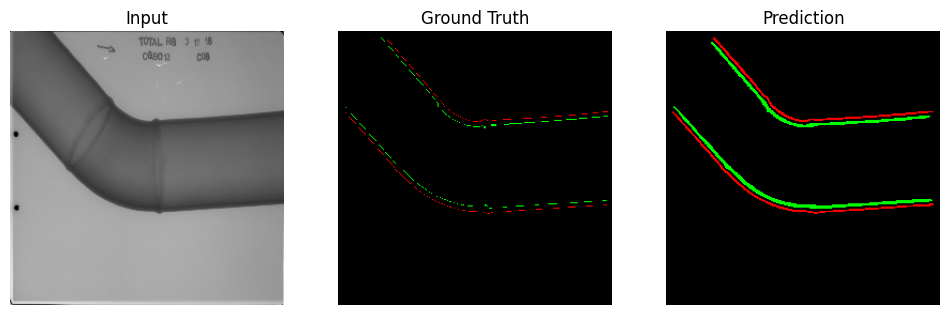

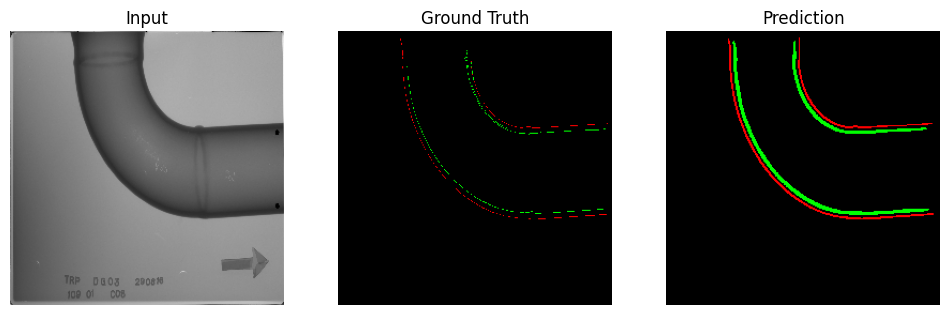

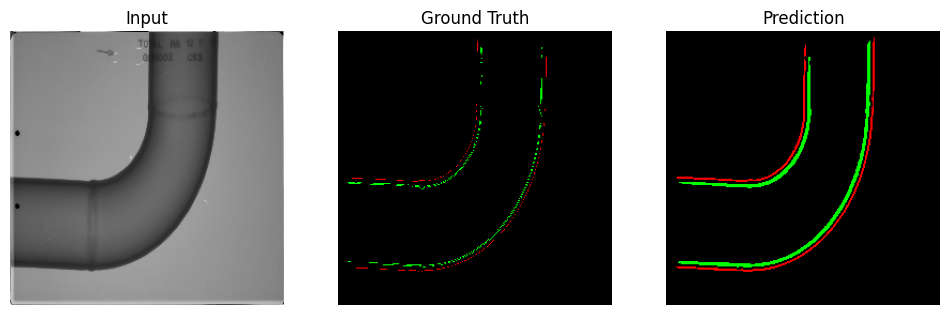

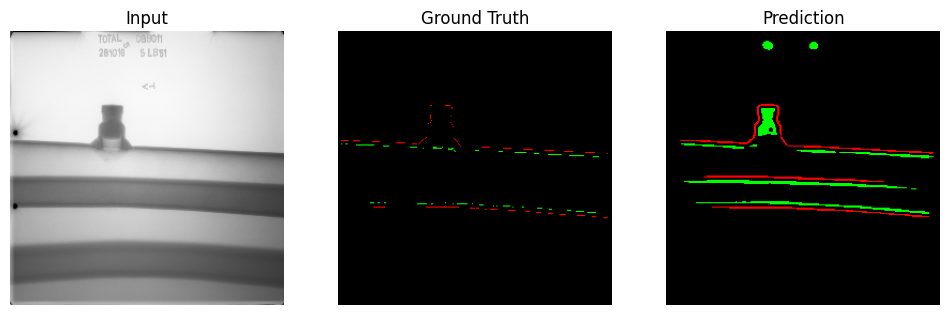

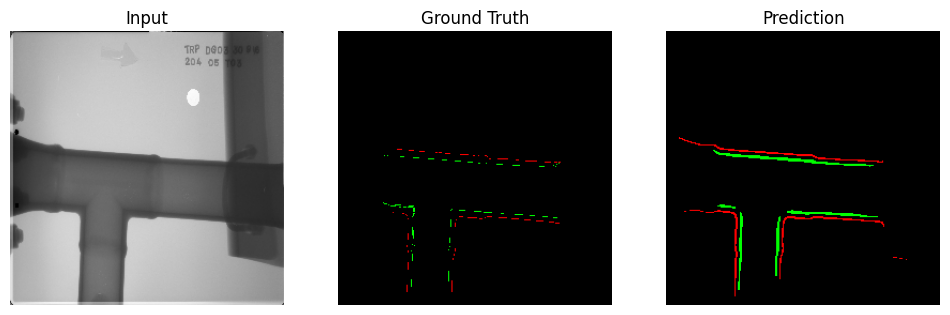

In [7]:
# Prediction & Postprocessing
def postprocess_mask(pred_mask):
    mask = np.argmax(pred_mask, axis=-1).astype(np.uint8)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    mask_clean = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return mask_clean

preds = model.predict(test_ds)
pred_labels = np.argmax(preds, axis=-1)
Y_test_labels = np.argmax(Y_test, axis=-1)

# Evaluation
from sklearn.metrics import jaccard_score

def calculate_iou(y_true, y_pred, class_id):
    y_true_flat = (y_true.flatten() == class_id).astype(np.uint8)
    y_pred_flat = (y_pred.flatten() == class_id).astype(np.uint8)
    return jaccard_score(y_true_flat, y_pred_flat)

for cls in range(NUM_CLASSES):
    iou = calculate_iou(Y_test_labels, pred_labels, cls)
    print(f"Class {cls} IoU: {iou:.4f}")

# Visualization
colors = [[0, 0, 0], [255, 0, 0], [0, 255, 0]]

def colorize_mask(mask):
    h, w = mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for class_id, color in enumerate(colors):
        color_mask[mask == class_id] = color
    return color_mask

for i in range(5):
    img = X_test[i]
    true_mask = np.argmax(Y_test[i], axis=-1)
    pred_mask = pred_labels[i]

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Input")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(colorize_mask(true_mask))
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(colorize_mask(pred_mask))
    plt.title("Prediction")
    plt.axis('off')

    plt.show()

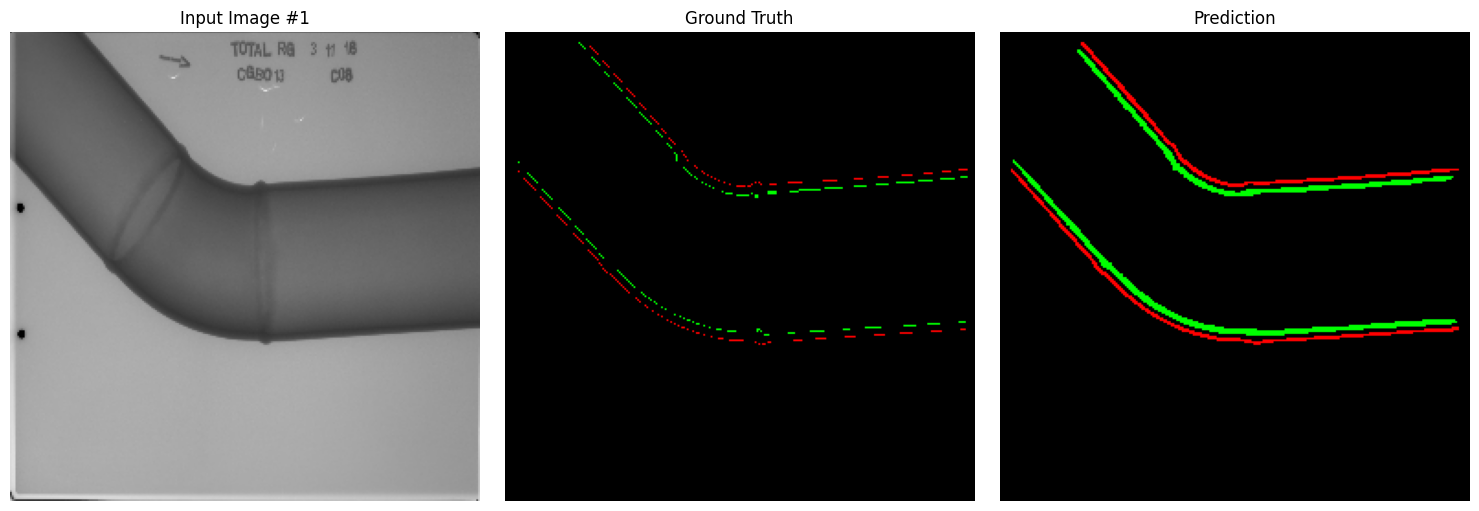

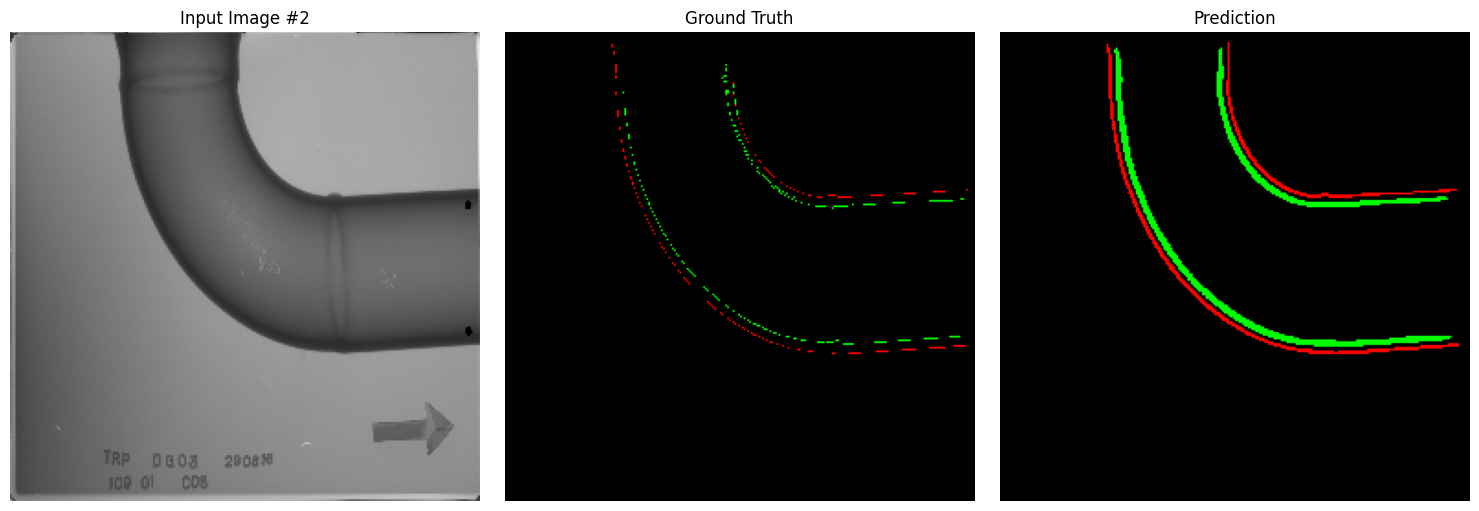

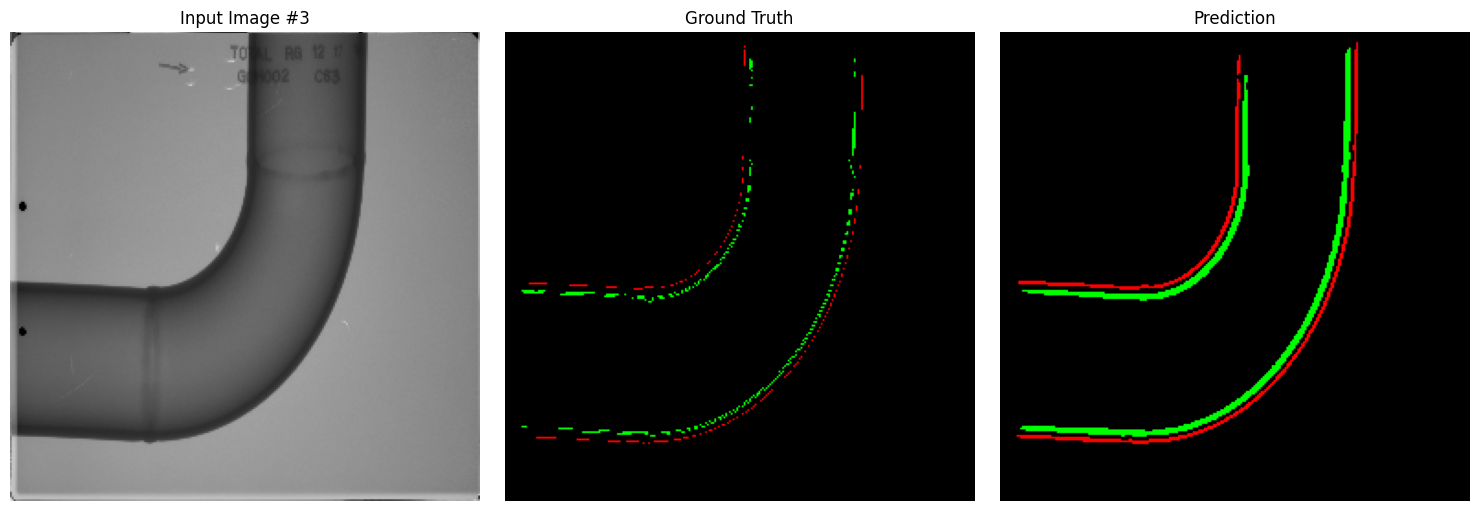

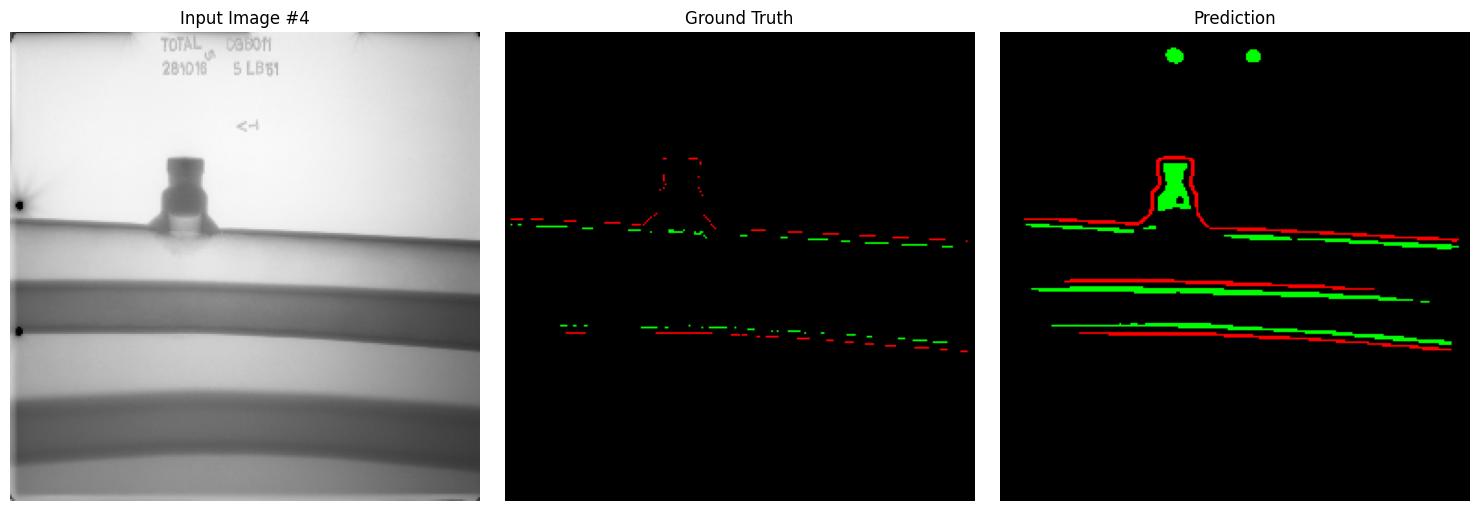

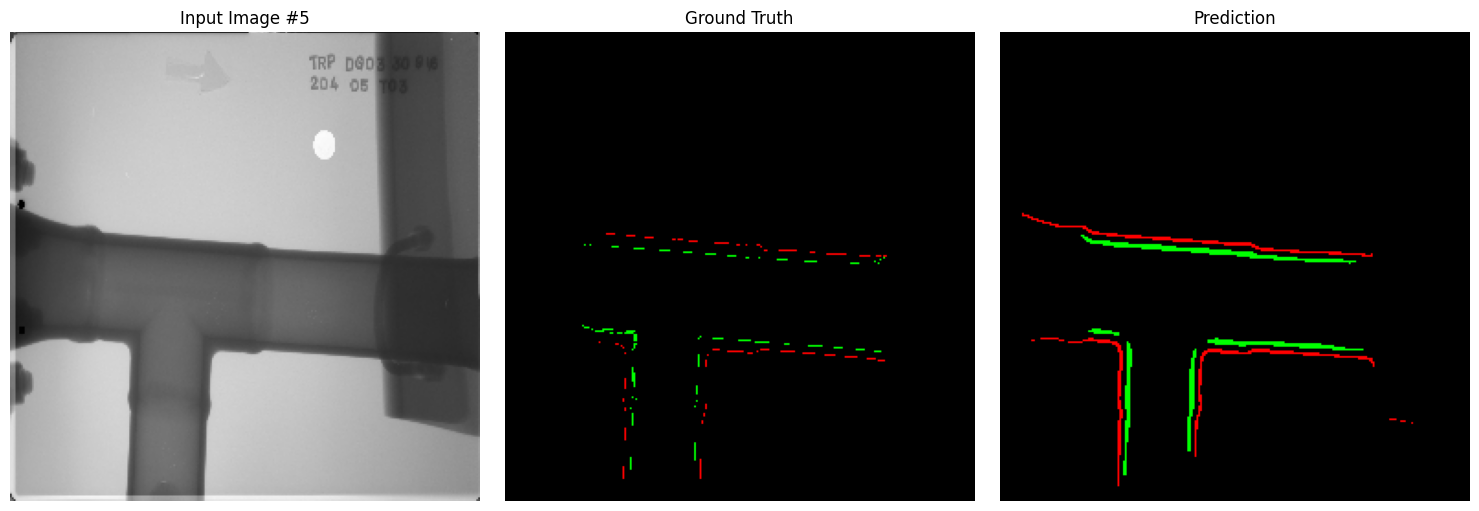

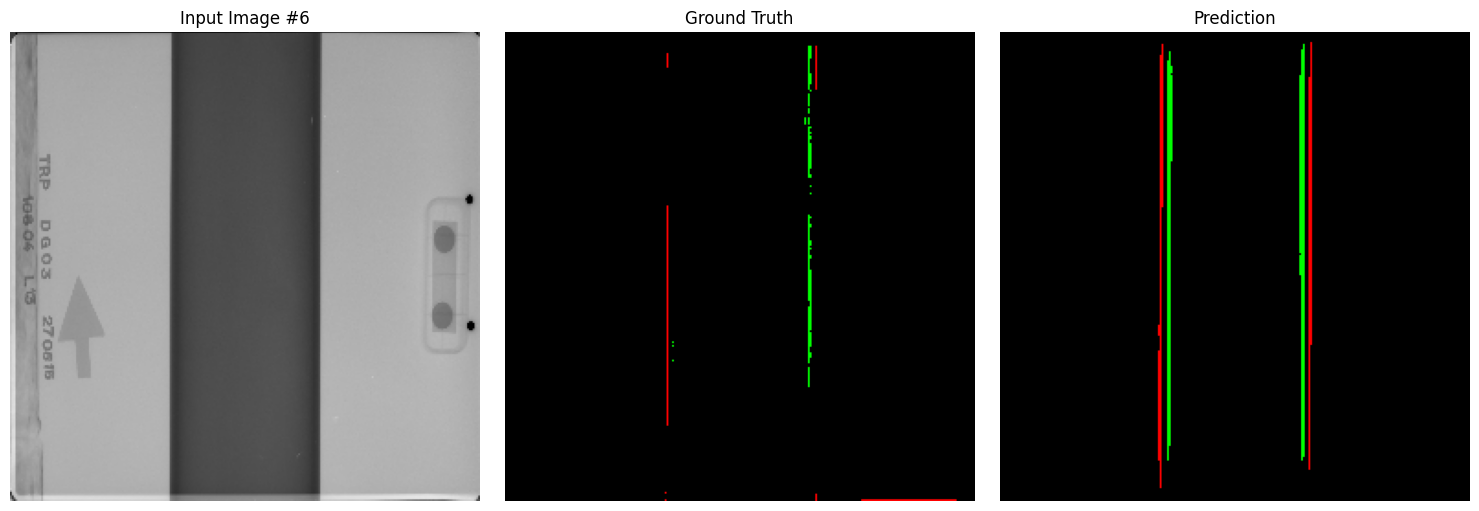

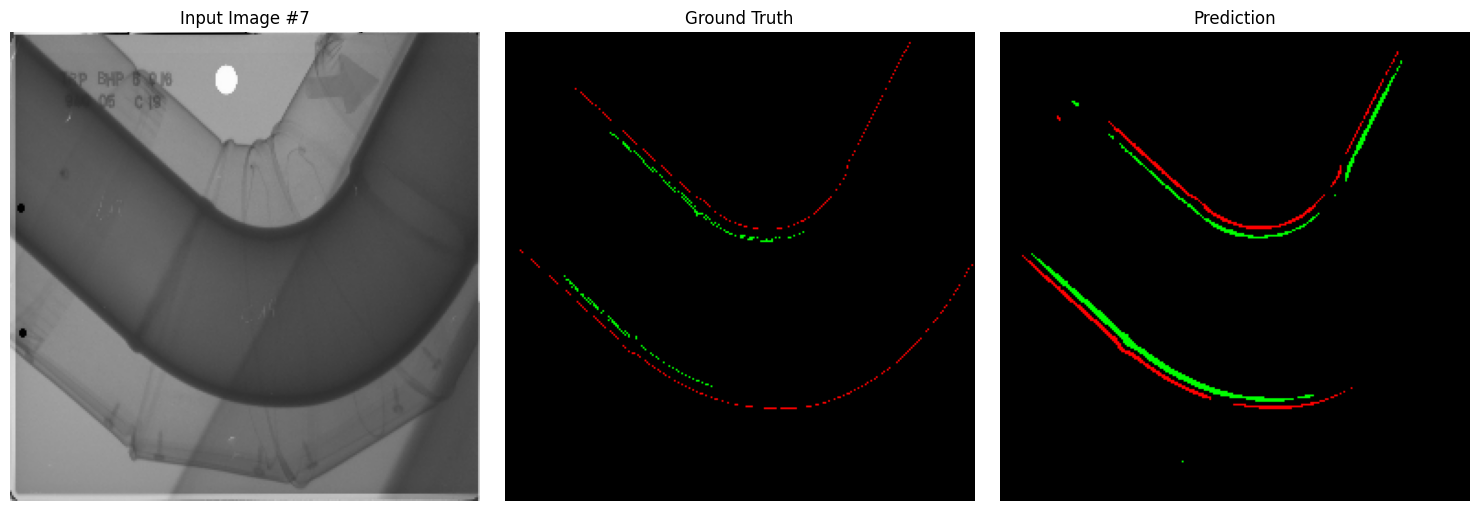

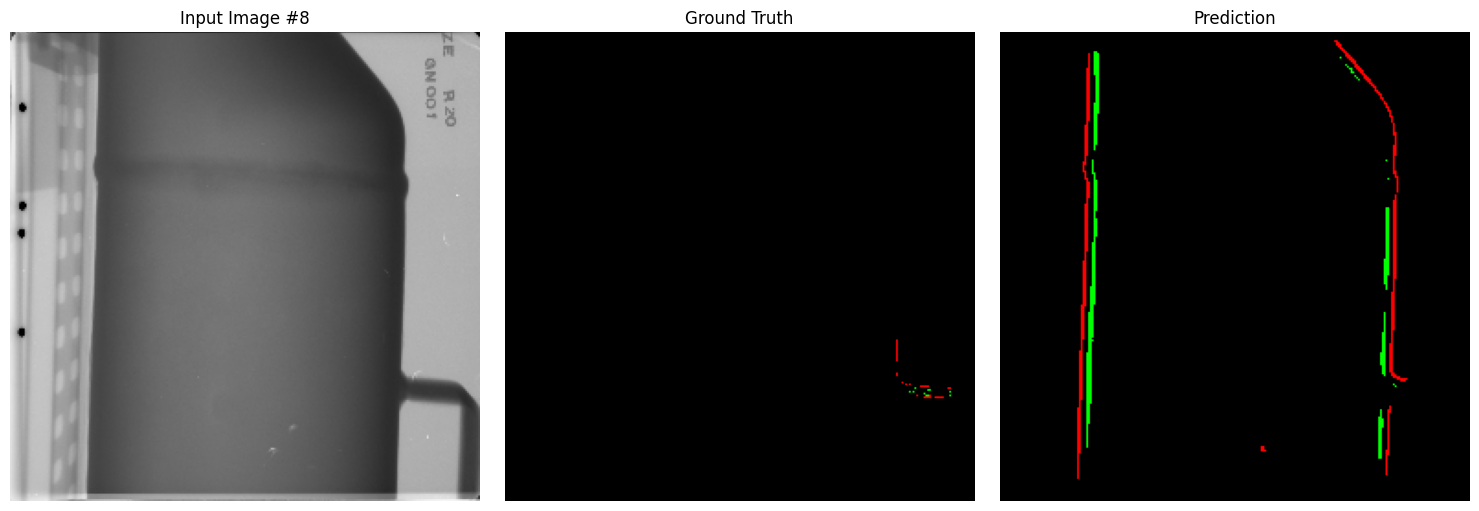

In [6]:
import matplotlib.pyplot as plt

num_visualize = min(20, len(X_test))  # visualize up to 20 or total available

for i in range(num_visualize):
    img = X_test[i]
    true_mask = np.argmax(Y_test[i], axis=-1)
    pred_mask = pred_labels[i]

    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Input Image #{i+1}")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(colorize_mask(true_mask))
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(colorize_mask(pred_mask))
    plt.title("Prediction")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


In [8]:
# 💾 Save the trained model as 'pipe.keras'
model.save("pipe.keras")

print("✅ Model saved as 'pipe.keras'")

✅ Model saved as 'pipe.keras'


In [9]:
# 💾 Save the model in Keras 2.x-compatible HDF5 format
model.save("pipes.h5")

print("✅ Model saved as 'pipe.h5' (Keras 2.x compatible)")


✅ Model saved as 'pipe.h5' (Keras 2.x compatible)


In [10]:
# === Clean up predicted mask ===
def postprocess_mask(pred_mask):
    mask = np.argmax(pred_mask, axis=-1).astype(np.uint8)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    mask_clean = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return mask_clean

# === Extract contours from the mask ===
def extract_contours(mask_clean):
    outer_mask = (mask_clean == 1).astype(np.uint8) * 255
    inner_mask = (mask_clean == 2).astype(np.uint8) * 255

    contours_outer, _ = cv2.findContours(outer_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours_inner, _ = cv2.findContours(inner_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    return contours_outer, contours_inner

# === Select largest contour (most likely the pipe) ===
def get_largest_contour(contours):
    return max(contours, key=cv2.contourArea) if contours else None

# === Compute thickness using enclosing circles ===
def calculate_thickness(outer_contour, inner_contour, pixel_to_mm=0.05):
    if outer_contour is None or inner_contour is None:
        print("❌ Contour missing. Thickness cannot be computed.")
        return None

    (_, _), r_out = cv2.minEnclosingCircle(outer_contour)
    (_, _), r_in = cv2.minEnclosingCircle(inner_contour)

    thickness_px = r_out - r_in
    thickness_mm = thickness_px * pixel_to_mm
    return thickness_mm

# === Visualize results ===
def visualize_results(img, mask_clean, thickness_mm=None):
    colors = [[0, 0, 0], [255, 0, 0], [0, 255, 0]]
    color_mask = np.zeros((*mask_clean.shape, 3), dtype=np.uint8)
    for cls, color in enumerate(colors):
        color_mask[mask_clean == cls] = color

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(color_mask)
    title = "Predicted Mask"
    if thickness_mm is not None:
        title += f"\nEstimated Thickness: {thickness_mm:.2f} mm"
    plt.title(title)
    plt.axis('off')
    plt.show()


In [11]:
def measure_pipe_thickness(img, pred_mask, pixel_to_mm=0.05):
    mask_clean = postprocess_mask(pred_mask)
    contours_outer, contours_inner = extract_contours(mask_clean)
    largest_outer = get_largest_contour(contours_outer)
    largest_inner = get_largest_contour(contours_inner)
    thickness_mm = calculate_thickness(largest_outer, largest_inner, pixel_to_mm)
    visualize_results(img, mask_clean, thickness_mm)
    return thickness_mm


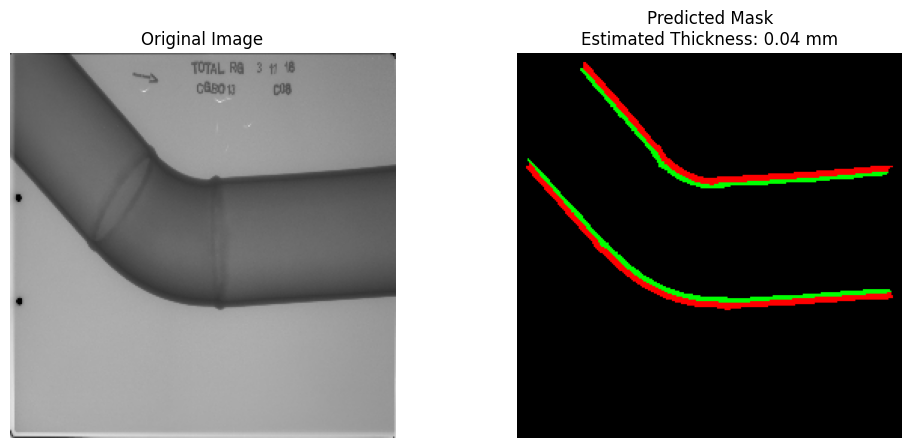

Estimated pipe wall thickness: 0.04 mm


In [12]:
# Example: compute thickness for one image
idx = 0  # pick any index from test set
img = X_test[idx]  # original image
pred_mask = preds[idx]  # predicted softmax mask from your model

thickness = measure_pipe_thickness(img, pred_mask, pixel_to_mm=0.05)
print(f"Estimated pipe wall thickness: {thickness:.2f} mm")
